<a href="https://colab.research.google.com/github/RenaFukuda99/BME2110Demo/blob/main/Polymerization_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chemical Kinetics and Polymerization Demo
## Part 1: Playing with reaction rates

### What factors influence reaction rates?
This will be our major "playground" for the first section of this demo. What factors influence reaction rate?

In [24]:
import numpy as np
import matplotlib.pyplot as plt

## PARAMETERS to vary
A0 = 5.0                 # Initial concentration [mol/L]
order = 1                # Order of reaction
temps = np.linspace(300, 800, 5)  # Temperature range
Ea = 75000       # Activation energy in J/mol
A_factor = 1e6  # Frequency factor

# CONSTANTS
R = 8.314  # J/(mol*K)
time = np.linspace(0, 1, 500) # time range

### The Arrhenius equation: Finding our rate constants
With the parameters we have, we can solve for the reaction CONSTANT using the Arrhenius equation.

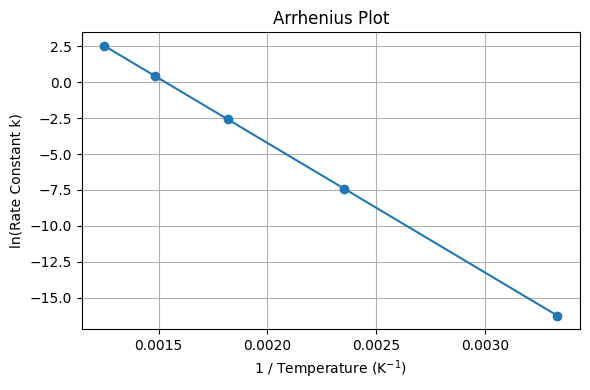

In [25]:
# FUNCTION: Arrhenius Equation
def arrhenius_eq(A, Ea, T):
    return A * np.exp(-Ea / (R * T))

# STEP 1: Find rate constant at each temperature
k_values = arrhenius_eq(A_factor, Ea, temps)

# STEP 2: Plot Arrhenius plot
plt.figure(figsize=(6,4))
plt.plot(1 / temps, np.log(k_values), 'o-')
plt.xlabel('1 / Temperature (K$^{-1}$)')
plt.ylabel('ln(Rate Constant k)')
plt.title('Arrhenius Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

### Reaction rate does not equal reaction constant.
How do we solve for reaction rate from reaction constant? That depends on reaction order.  

In [26]:
# FUNCTION: Solving for concentration vs. time (for any reaction order)
def concentration_vs_time(order, A0, k, time):
    if order == 1:
        return A0 * np.exp(-k * time)
    else:
        conc = ((order - 1) * k * time + A0**(1 - order))**(1 / (1 - order))
        return np.maximum(conc, 0)

In [ ]:
# Using rates to predict concentration over time

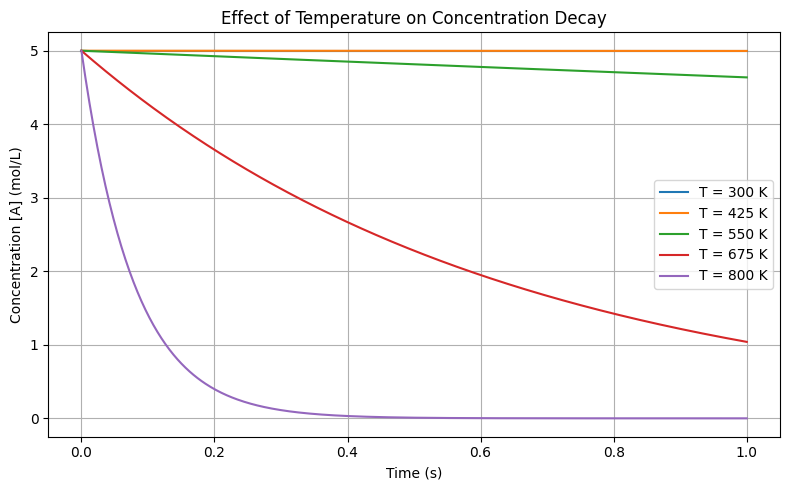

In [27]:
# Simulate [A] vs time for each temperature
plt.figure(figsize=(8, 5))
for idx, k_now in enumerate(k_values):
    conc = concentration_vs_time(order, A0, k_now, time)
    plt.plot(time, conc, label=f"T = {int(temps[idx])} K")

# Plot Concentration vs Time
plt.xlabel('Time (s)')
plt.ylabel('Concentration [A] (mol/L)')
plt.title('Effect of Temperature on Concentration Decay')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 2: Polymerization

### How do we predict slightly more complicated reactions?

In [31]:
# PARAMETERS to vary
M0 = 1e3  # Initial monomer concentration (mol/L)
I0 = 1e-4  # Initial initiator concentration (mol/L)
T_array = np.array([300, 320, 340, 360])  # Temperatures (K)
A = 1e6  # Pre-exponential factor (L/s*mol)
Ea = 75e3  # Activation energy (J/mol)

# Constants
R = 8.314  # Gas constant (J/mol·K)

In [32]:
def polymerization_simulation(k, M0, I0, time_steps, dt, M_weight):
    # Initial values
    monomer = M0 # Monomer conc
    initiator = I0 # Initiator conc
    polymer = 0 # Polymer conc

    # Initialize lists
    monomer_list = [monomer]
    initiator_list = [initiator]
    polymer_list = [polymer]
    molecular_weights = []
    Mn = [M_weight]  # Number average molecular weight
    DP = [1]         # Degree of polymerization
    PDI = [1]        # Polydispersity index

    for t in range(1, time_steps):
        if monomer <= 0 or initiator <= 0:
            break

        # Rate of polymerization
        R_p = k * monomer * np.sqrt(initiator)

        # Update concentrations
        dM = R_p * dt
        monomer = max(monomer - dM, 0)
        initiator = max(initiator - dM / 2, 0)
        polymer += dM

        monomer_list.append(monomer)
        initiator_list.append(initiator)
        polymer_list.append(polymer)

        # Molecular weight calculation
        if monomer > 0:
            chain_length = polymer / monomer
            molecular_weights.append(chain_length * M_weight)
        else:
            molecular_weights.append(molecular_weights[-1])  # Hold last value

        # Degree of polymerization
        dp = (M0 - monomer) * k * dt
        DP.append(DP[-1] + dp)

        # Mn = DP * monomer weight
        Mn.append(DP[-1] * M_weight)

        # PDI estimation
        PDI.append(molecular_weights[-1]/Mn[-1])

    return {
        "monomer": monomer_list,
        "initiator": initiator_list,
        "polymer": polymer_list,
        "molecular_weights": molecular_weights,
        "Mn": Mn,
        "DP": DP,
        "PDI": PDI
    }

### What can we predict using our simulation??

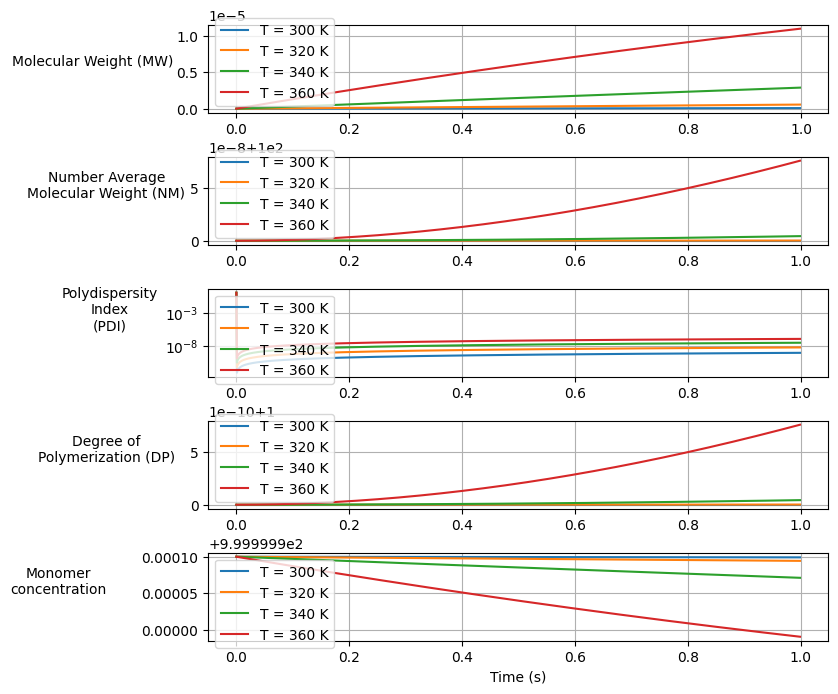

In [8]:
## Plot it all!
# Simulation parameters
time_steps = 1000
dt = 0.001  # Time step (s)

# Set figure dimensions
fig, axs = plt.subplots(5)
fig.set_size_inches(8, 8)

# Plot all relevant measures
for idx, k_now in enumerate(k_array):

    # Pass each rate constant from Arrhenius into polymerization function
    result = polymerization_simulation(k_now, M0, I0, time_steps, dt, 100)

    # Read out all relevant measures
    time = np.arange(len(result["PDI"])) * dt
    axs[1].plot(time, result["Mn"], label=f"T = {T_array[idx]} K")
    axs[2].plot(time, result["PDI"], label=f"T = {T_array[idx]} K")
    axs[3].plot(time, result["DP"], label=f"T = {T_array[idx]} K")
    axs[4].plot(time, result["monomer"], label=f"T = {T_array[idx]} K")
    time_mw = np.arange(len(result["molecular_weights"])) * dt
    axs[0].plot(time_mw, result["molecular_weights"], label=f"T = {T_array[idx]} K")

# Label axes
axs[0].set_ylabel("Molecular Weight (MW)", rotation=0, labelpad = 60)
axs[1].set_ylabel("Number Average\nMolecular Weight (NM)", rotation=0, labelpad = 60)
axs[2].set_ylabel("Polydispersity\nIndex\n(PDI)", rotation=0, labelpad = 40)
axs[3].set_ylabel("Degree of\nPolymerization (DP)", rotation=0, labelpad = 60)
axs[4].set_ylabel("Monomer\nconcentration", rotation=0, labelpad = 60)
axs[2].set_yscale('log')
axs[4].set_xlabel("Time (s)")

# Misc. formatting
for ax in axs:
    ax.grid(True)
    ax.legend(loc='best')
fig.subplots_adjust(wspace=1, hspace=.5)